# 데이콘 소득 예측 경진대회 EDA

- 예측이지만, binary classification 문제
- 간단한 EDA와 변수 가공
- NA처리와 패턴 분석을 주로 수행.

# 변수 설명

```
id : 샘플 아이디
age : 나이
workclass : 일 유형 (범주)
fnlwgt : CPS(Current Population Survey) 가중치 (이 사람이 표본에 뽑힐 가능성에 따른 가중치. 높을수록 뽑히기 어려운 사람?)
education : 교육수준 (범주)
education.num : 교육수준 번호 (범주)
marital.status : 결혼 상태 (범주)
occupation : 직업 (범주)
relationship : 가족관계 (범주)
race : 인종 (범주)
sex : 성별 (범주)
capital.gain : 자본 이익 (부동산, 토지, 주식 등)
capital.loss : 자본 손실
hours.per.week : 주당 근무시간
native.country : 본 국적 (범주)
target : 소득 (target)
					   0 = <=50K (5만 달러 이하)

					   1 = >50K (5만 달러 초과) 
```


- 이를 통해 생각한 가설들.
    - 'education'과 'education.num' 둘 중 하나만 사용면되는 dummi 변수로 생각된다.
    - 'workclass'와 'occupation'이 둘다 비어있는 경우, 백수로 취급하고 level을 추가해도 된다.(workclass na, occupation na 둘다인 경우)
    - sample submit 결과, target의 불균형이 크다. stratified kfold를 사용을 고려한다.
    - 나이도 더미변수로 활용해 보는 것이 좋아보인다.
    - 본 국적을, 해외 노동자 여부 (0,1 로 바꾸는건 어떨까? 그대로 쓰면, curse of dimmension 일 듯하다.)
    - marital.status와 성별이 있다면, relation-ship이 필요할지. (다중 공선성 문제)




In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import sys

In [2]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

# 데이터 확인

In [3]:
# 파일 불러오기
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
#submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
train

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [5]:
test

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,30,Local-gov,182926,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States
15077,15077,39,Private,176101,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
15078,15078,48,Private,242406,11th,7,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,Puerto-Rico
15079,15079,44,Private,100584,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States


In [6]:
# 데이터 차원 확인하기
print('train : ',train.shape)
print("test : ", test.shape)

train :  (17480, 16)
test :  (15081, 15)


## 타입 체크


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              17480 non-null  int64 
 1   age             17480 non-null  int64 
 2   workclass       15644 non-null  object
 3   fnlwgt          17480 non-null  int64 
 4   education       17480 non-null  object
 5   education.num   17480 non-null  int64 
 6   marital.status  17480 non-null  object
 7   occupation      15637 non-null  object
 8   relationship    17480 non-null  object
 9   race            17480 non-null  object
 10  sex             17480 non-null  object
 11  capital.gain    17480 non-null  int64 
 12  capital.loss    17480 non-null  int64 
 13  hours.per.week  17480 non-null  int64 
 14  native.country  16897 non-null  object
 15  target          17480 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.1+ MB


- 3컬럼 정도가 na가 있음을 알 수있다.
- 그리고 가설에서 예상했던 것처럼, workclass가 na면 ocupation도 na일 가능성이 높아보인다. (백수예상)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education.num   15081 non-null  int64 
 6   marital.status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital.gain    15081 non-null  int64 
 12  capital.loss    15081 non-null  int64 
 13  hours.per.week  15081 non-null  int64 
 14  native.country  15081 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.7+ MB


In [24]:
np.sum(test.isna())

id                0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

test set에는 na는 없다.

# 범주형 level 확인

In [18]:
print('educatuon \n',train['education'].unique())
print('educatuon.num \n',train['education.num'].unique())

print('workclass \n',train['workclass'].unique())

print('marital.status \n',train['marital.status'].unique())

print('occupation \n',train['occupation'].unique())

print('relationship \n',train['relationship'].unique())

print('race \n',train['race'].unique())

print('sex \n',train['sex'].unique())

print('native.country \n',train['native.country'].unique())

educatuon 
 ['Assoc-acdm' 'Some-college' 'Bachelors' 'HS-grad' 'Prof-school' '10th'
 '11th' 'Masters' '7th-8th' '1st-4th' 'Assoc-voc' '5th-6th' 'Doctorate'
 '9th' '12th' 'Preschool']
educatuon.num 
 [12 10 13  9 15  6  7 14  4  2 11  3 16  5  8  1]
workclass 
 ['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
education 
 ['Assoc-acdm' 'Some-college' 'Bachelors' 'HS-grad' 'Prof-school' '10th'
 '11th' 'Masters' '7th-8th' '1st-4th' 'Assoc-voc' '5th-6th' 'Doctorate'
 '9th' '12th' 'Preschool']
marital.status 
 ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated'
 'Married-AF-spouse' 'Married-spouse-absent' 'Widowed']
occupation 
 ['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
relationship 
 ['Husband' 'Own-child' 'Not-in-fami

같은 범주인데도, 오타가 없는지 확인해본다.

## NA 체크

- dacon sample 함수 사용

In [10]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: workclass 입니다
해당 컬럼에 총 1836 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: occupation 입니다
해당 컬럼에 총 1843 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: native.country 입니다
해당 컬럼에 총 583 개의 결측치가 존재합니다.


결측치가 있는 row들을 확인.

In [11]:
# 결측치가 있는 row들을 확인합니다.
train[train.isna().sum(axis=1) > 0]

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15083,15083,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,1
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15085,15085,22,Private,119592,Assoc-acdm,12,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,2824,40,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


보다시피, NA값이 너무 많아서 가설에 따라 데이터를 채워 주려고한다.

가설확인을 위해 workclass와 occupation 둘다 na인 행 출력

In [12]:
type1= train['workclass'].isna()
type2= train['occupation'].isna()

two_na=train[type1&type2]
two_na

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15086,15086,61,NaN,135285,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2603,32,United-States,0
15087,15087,71,NaN,100820,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2489,15,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


예상과 다르게, 결혼도 안했고 workclass&occupation이 na인데도( two_na ) 고소득층이 존재.

이런 경우가 진짜 NA값이라 생각해서 제거해주거나 패턴을 확인.

더 자세히 분석하기위해, two_na데이터를 target에 따라 feature 별 시각화.

In [13]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'],axis = 1) #범주형이 아닌 피쳐 drop
two_na_cate.head()

,education,marital.status,relationship,race,sex,native.country,target
15081,HS-grad,Widowed,Not-in-family,White,Female,United-States,0
15082,Some-college,Widowed,Unmarried,Black,Female,United-States,0
15084,Doctorate,Never-married,Not-in-family,White,Male,United-States,1
15086,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0
15087,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0


In [15]:
print('workclass & occupation 이 na지만, 고소득층인 경우',len(two_na_cate[two_na_cate['target']==1]) )

workclass & occupation 이 na지만, 고소득층인 경우 191


191건 정도는 날려도 된다고 생각하지만, capital gain이 높을 수도 있어서, 확인해본다.

<AxesSubplot:title={'center':'capital gain and marriage'}, xlabel='marital.status', ylabel='capital.gain'>

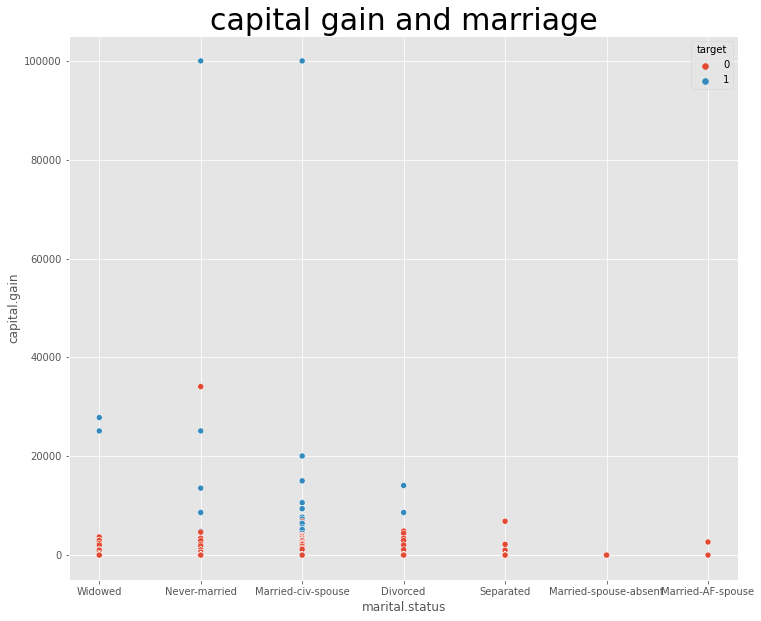

In [54]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education.num', 'hours.per.week'],axis = 1) #범주형이 아닌 피쳐 drop

plt.figure(figsize=(12, 10))
plt.title('capital gain and marriage', fontsize = 30)
sns.scatterplot(x = 'marital.status',y= 'capital.gain', hue= 'target', data= two_na_cate)

two_na 고소득자(target==1) 중에서, gain을 확인해본 결과,

married를 제외하고, capital gain이 50k 이하인 것은 제거하는 것이 옳다고 보인다.(직업이 있음에도, 직업을 알 수 없는 경우이다.)

# 범주형 데이터

## workclass & occupation

workclass 와 occupation의 na값을 위주로 분석

## 본 국적 확인 (native.country )

본 국적에 na값이 많아서 다 제거하고 싶으나, 카이제곱 검정을 통해 나라에 따라 영향이 있는지 검정하려고함.

또한, 미국 vs 그외로 분류 해볼 생각.

In [20]:
print('native country na 수 :',len(train[train['native.country'].isna()] ))

native country na 수 : 583


In [39]:
native_country_table=train['native.country'].value_counts()
native_country_table

United-States                 15393
Mexico                          355
Philippines                     108
Germany                          75
Canada                           63
Puerto-Rico                      59
El-Salvador                      58
Cuba                             49
India                            47
England                          46
Jamaica                          42
China                            40
South                            39
Italy                            38
Dominican-Republic               38
Columbia                         37
Guatemala                        36
Poland                           35
Japan                            33
Vietnam                          32
Taiwan                           28
Haiti                            23
Nicaragua                        20
Portugal                         20
Ecuador                          19
Ireland                          18
Iran                             17
Peru                        

### 단변량 그림

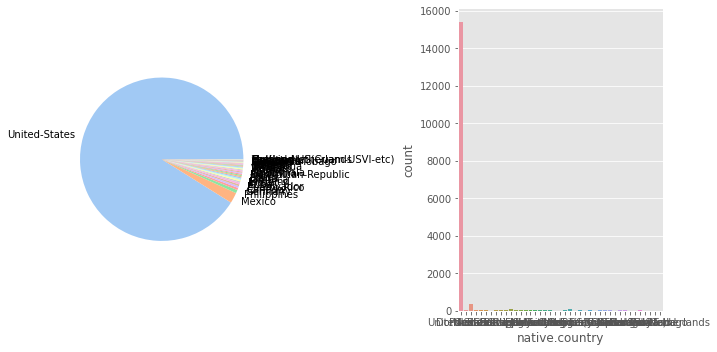

In [53]:
colors = sns.color_palette('pastel')[0:42]
#create pie chart
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.pie(train['native.country'].value_counts(),labels=native_country_table.index,colors=colors)
plt.subplot(1,2,2)
sns.countplot(data=train, x="native.country")


#sns.countplot(data=train, x="native.country")
plt.tight_layout()
plt.show()

미국,멕시코 순으로 빈도가 많다. 그 외의 국가는 매우 희소하다.

### 이변량 그림

target vs 본 국적

In [72]:
country_crosstab=pd.crosstab(train['native.country'],train['target'])
country_crossgtab_res=chi2_contingency(country_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(country_crossgtab_res[0], country_crossgtab_res[1]))

Chi2 Statistic: 198.0845348336186, p-value: 8.189153114434088e-23
국적에 따라, 차이가 있음을 검정을 통해서 확인 할 수 있다. 


독립성 검정결과 국적에 따라, 차이가 있음을 검정을 통해서 확인 할 수 있다.

하지만, 국적별로 도수가 크게 다르기 때문에 검정 결과를 신뢰할 수는 없어서 분포를 본다.

In [ ]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=titanic, ax=ax2)  



<AxesSubplot:xlabel='native.country', ylabel='Density'>

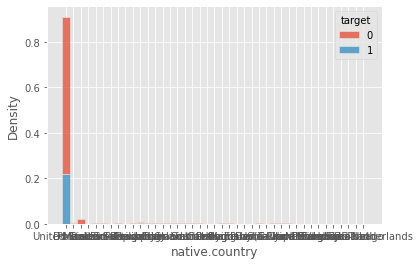

In [112]:
#모자이크 플롯 (~hist plot으로 대체)
#sns.barplot(data=train,x="native.country",y='target',)
sns.histplot(data=train, x="native.country", hue="target",discrete=True,multiple="stack", stat="density")

<AxesSubplot:xlabel='native.country', ylabel='Probability'>

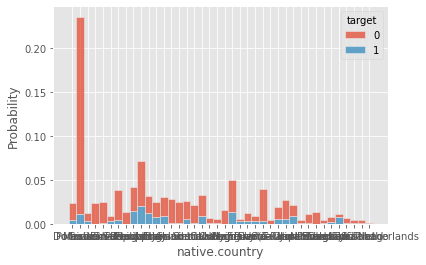

In [105]:

#모자이크 플롯
sns.histplot(data=train[train['native.country']!='United-States'], x="native.country", hue="target", multiple="stack")

대부분 국가들이 미국에 비해서, 비율이 낮아보인다.

미국은 약 7.6:2.4 정도 비율로,
비율에 따라 분류하려고 한다.

비율이 20% 이상인 국가,

이하인 국가로 묶기


In [93]:
upper_country=[]
lower_country=[]

for country in train['native.country'].unique():
    country_data=train[train['native.country']==country]['target']
    probs=sum(country_data)/country_data.count()
    if probs >=0.2:
        upper_country.append(country)
    elif probs < 0.2:
        lower_country.append(country)
    print(country,probs)

United-States 0.24062885727278632
Poland 0.2
Mexico 0.04507042253521127
Ireland 0.2222222222222222
Guatemala 0.0
Dominican-Republic 0.02631578947368421
Greece 0.35714285714285715
El-Salvador 0.1206896551724138
Portugal 0.0
Canada 0.3492063492063492
Philippines 0.28703703703703703
India 0.40425531914893614
Italy 0.3157894736842105
England 0.30434782608695654
Jamaica 0.047619047619047616
Columbia 0.02702702702702703
South 0.23076923076923078
Vietnam 0.03125
Cuba 0.2653061224489796
Laos 0.2
Hong 0.2222222222222222
Haiti 0.0
Germany 0.26666666666666666
Yugoslavia 0.4444444444444444
Ecuador 0.21052631578947367
France 0.2857142857142857
Puerto-Rico 0.0847457627118644
Outlying-US(Guam-USVI-etc) 0.0
Taiwan 0.2857142857142857
China 0.2
Japan 0.3939393939393939
Honduras 0.14285714285714285
Peru 0.11764705882352941
Nicaragua 0.0
Hungary 0.2857142857142857
Cambodia 0.2727272727272727
Iran 0.6470588235294118
Trinadad&Tobago 0.1
Thailand 0.16666666666666666
Scotland 0.14285714285714285
Holand-Nether

C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [94]:
print('upper:',upper_country)
print('lower:',lower_country)

upper: ['United-States', 'Poland', 'Ireland', 'Greece', 'Canada', 'Philippines', 'India', 'Italy', 'England', 'South', 'Cuba', 'Laos', 'Hong', 'Germany', 'Yugoslavia', 'Ecuador', 'France', 'Taiwan', 'China', 'Japan', 'Hungary', 'Cambodia', 'Iran']
lower: ['Mexico', 'Guatemala', 'Dominican-Republic', 'El-Salvador', 'Portugal', 'Jamaica', 'Columbia', 'Vietnam', 'Haiti', 'Puerto-Rico', 'Outlying-US(Guam-USVI-etc)', 'Honduras', 'Peru', 'Nicaragua', 'Trinadad&Tobago', 'Thailand', 'Scotland', 'Holand-Netherlands']


분류결과, 어느정도 개발도상국과 아닌국가로 나눠진듯 하다.

물론 도수가 적어서 outlier도 존재한다.

<AxesSubplot:title={'center':'native.country and age'}, xlabel='native.country', ylabel='age'>

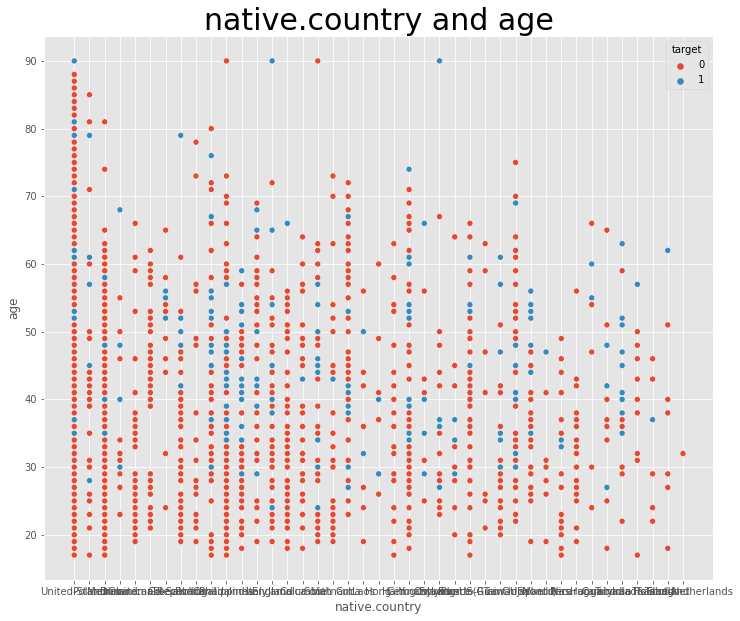

In [62]:
plt.figure(figsize=(12, 10))
plt.title('native.country and age', fontsize = 30)
sns.scatterplot(x = 'native.country',y= 'age',hue='target' ,data= train)

### 그외 변수들

# 수치형 데이터 분포 확인

# 변수 가공

앞에서 찾은 인사이트들로, 변수 가공을 수행


In [ ]:
#NA 처리

In [ ]:
#education num 제거

In [ ]:
#나이데이터 수정.

# 변수 중요도 확인

# 결론


1. workclass &  occupation이 둘다 na인 경우, 상황에따라 제거하거나 without_payment, occupation : baeksu 라는 level을 만들어 삽입해주었다.
2. education과 education.num은 education.num만 남겼다. 
3. 나이 데이터를 수치형에서 범주형으로 변경. 특정 나이대에 따라 소득 여부가 확실히 보이기 때문.
4. 국적데이터 컬럼을 제거했다.